# Preamble

We'll start by formatting the notebook, and running some diagnostics for checking the systems sound output is working correctly. Then, I've imported the Python modules required.

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [103]:
import matplotlib
import librosa 
import matplotlib.pyplot as plt ## For plots and visual data
import IPython.display as ipd ## For displaying audio widgets
import lightkurve as lk ## For generation of light curves
import matplotlib.pyplot as plt ## Standard visual data creation module
import librosa.display
import numpy as np
import os
import pandas as pd
import sqlite3 ## Database creation
import mysql.connector
import jupyterthemes
import math
import matplotlib.animation as animation
import random
import ffmpeg
import sys
import datetime
import os.path
from os.path import abspath

from astronify.series import SoniSeries ## For sonifying the data
from lightkurve import search_targetpixelfile ## 2D pixel heatmaps etc.
from astropy.io import fits
from astropy.table import Table
from astronify import simulator, series
from celluloid import Camera
from pyo import *
from pathlib import Path
matplotlib.rcParams.update({'font.size': 22})

# Setting light curve parameters

Here we'll set some parameters for the curves we want to produce. With six values of signal-to-noise, and three values for the number of transits (0, 1 and 2, note 0 transit curves are done separately), 18 curves will be generated. 

From the values of SNR we want to test at, we can obtain a value for the corresponding standard deviation of noise which is calculated depending on the transits width and depth. This is what astronify takes as input for it's noise parameter. We can also obtain a parameter for the distance between transits which I've called freq_param. This equates to 1000 for curves of one transit, and 500 for curves of two.

In [60]:
snr = [3,5,7,10,30,100] # The signal to noise ratio we are testing for
transit_length = 1000 # Affects length of sonification, we wanted to keep this at about 10 seconds and 1000 was appropriate
t_depth = 25 # The depth of the transit as a percentage of the brightness flux
width_param = 0.1 # Transit length as fraction of total
transit_n = [1,2] # Number of transits we want in the data
t_width = transit_length*width_param # In our case, 100

noise_sd = [] 
for x in snr:
    noise_sd.append(np.sqrt(t_width)*t_depth/x) ## The actual noise sigma values for astronify
    
freq_param = []
for x in transit_n:
    freq_param.append(int(transit_length/x)) # This is why zero-transit data is done separately

In [61]:
t_width

100.0

In [59]:
"Standard deviations of noise to put in are:" ,noise_sd

('Standard deviations of noise to put in are:',
 [83.33333333333333, 50.0, 35.714285714285715, 25.0, 8.333333333333334, 2.5])

In [6]:
"Transit periods:", freq_param

('Transit periods:', [1000, 500])

# Generating an example transit with noise and no noise

Now we're ready to start using astronify to generate transit light curves. To get a sense of how our curves look, we'll start with a curve of one transit, using the formula t_start to semi-randomize the position of the transit (this is to avoid it being directly at the start mainly). Astronify has also been used in the noisy transit to sonify and play the data with a given set of parameters. We were informed on these by the developers. 

You will notice by running this next cell multiple times that the start of the transit will be at a different place each time (note you can also change n_transit and experiment with curves of a different number of transits). Due to the randomness of the transit starts, the generated dataset won't be exactly the same as the one with which I carried out the user testing.

Saving to the system is currently commented out.

Text(0, 0.5, 'Brightness flux (arbitrary units)')

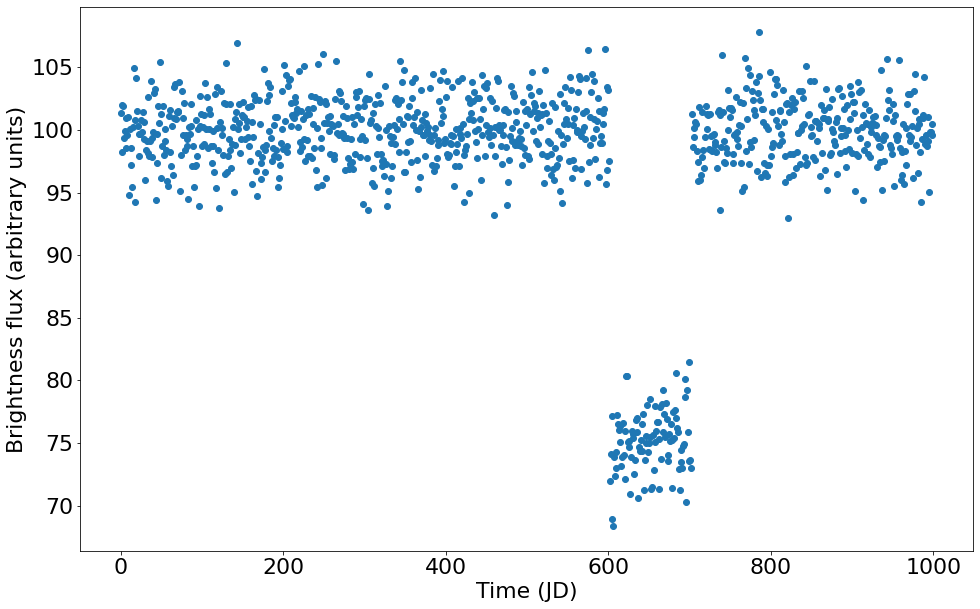

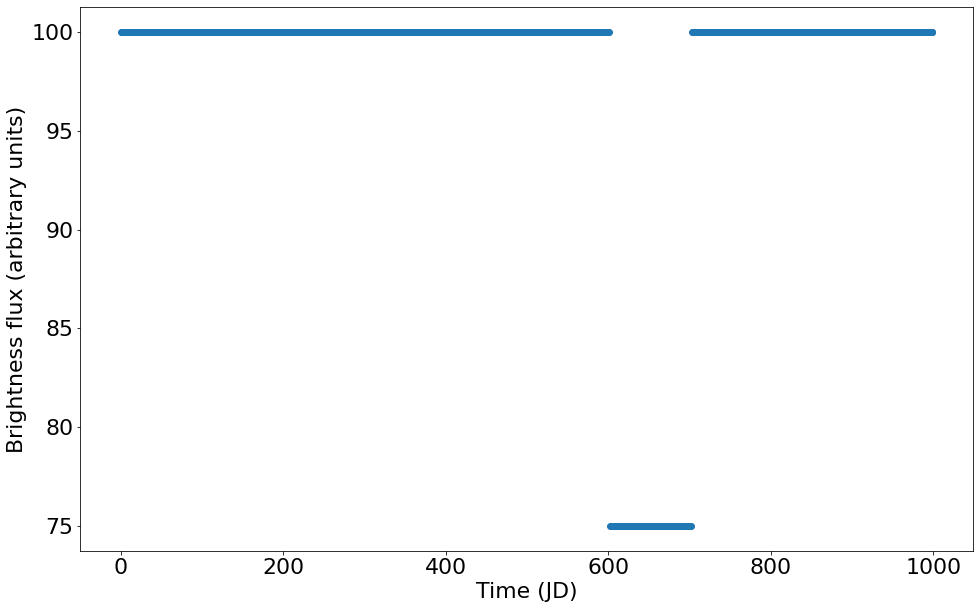

In [12]:
n_transit = 1
t_period = int(transit_length/n_transit)
t_start = int(transit_length/(2.*n_transit)-t_width/2. + random.randint(-1*t_period/4, t_period/4))

lc_data_noise = simulator.simulated_lc("transit", visualize=False, 
                                       transit_depth=int(t_depth), transit_period=t_period,
                                       transit_width=int(t_width), lc_noise=2.5, 
                                       lc_length=int(transit_length),transit_start=t_start)

f, ax = plt.subplots(figsize=(16, 10))
ax.plot(lc_data_noise['time'], lc_data_noise['flux'],'-o', linewidth=0)
ax.set_xlabel("Time (JD)")
ax.set_ylabel("Brightness flux (arbitrary units)")

lc_sound_transit = series.SoniSeries(lc_data_noise)
lc_sound_transit.pitch_mapper.pitch_map_args["stretch"] = 'linear'
lc_sound_transit.pitch_mapper.pitch_map_args["pitch_range"] = [440,880]
lc_sound_transit_spacing = 0.01
lc_sound_transit.note_duration = 0.2
lc_sound_transit.sonify()

#lc_sound_transit.play()
#plt.savefig("Example noisy transit.png")

lc_data_noiseless = simulator.simulated_lc("transit", visualize=False, 
                                           transit_depth=int(t_depth), transit_period=t_period,
                                           transit_width=int(t_width), lc_noise=0, 
                                           lc_length=int(transit_length),transit_start=t_start)

f, ax = plt.subplots(figsize=(16, 10))
ax.plot(lc_data_noiseless['time'], lc_data_noiseless['flux'],'-o', linewidth=0)
ax.set_xlabel("Time (JD)")
ax.set_ylabel("Brightness flux (arbitrary units)")

#plt.savefig("Example noiseless transit.png")

# Light curve generator

## Building database of the parameters for reference

Now we can prepare to build a database of light curves of varying parameters. As we need to refer back to the properties of these curves after the user testing, we'll create a database that contains the variables (number of transits and signal-to-noise). Note if you run the cells in section 5 which actually generate light curves multiple times, you'll need to go back and rerun this cell to start with a fresh database.

In [122]:
if 'df' in locals(): # To make sure we start with an empty database
    del df
    
df = pd.DataFrame({'Number of transits': [],
                   'Value of SNR': [],
                   'Tag': []})
display(df)

,Number of transits,Value of SNR,Tag


## Curves with 1 and 2 transits

So we can tell exactly what the generator is doing (just an iterative loop that creates 12 curves for the two values in transit_n, 1 and 2, and the 6 standard deviation values of noise) we'll also create a noiseless version of the curve for reference.

The actual code here is relatively simple - the important part is that k represents a unique, randomized tag, that is assigned to each curve. This is so the curves are 'anonymous' to users, i.e. their SNR and number of transits are not in the filename, hence why having the database to refer back to each curves' properties is so essential.

Note the relevant code for saving the sonifications and plots to the system is currently commented out.

In [123]:
for j in transit_n:
                   
    for i in noise_sd:
        
        # Relating the transit start to the number of transits we want in the curve, from the set [1,2]
        t_start = int(transit_length/(2.*j)-(transit_length*width_param)/2. + 
                      random.randint(-1*(transit_length/j)/4, (transit_length/j)/4)) 
        
        k = int(random.uniform(5*len(df),(5*len(df)+4))) # k is related to the iteration of the for loop, so is unique.
        
        lc_data_transit = simulator.simulated_lc("transit", 
                                         visualize = False, 
                                         transit_depth = t_depth,
                                         transit_period = transit_length/j, 
                                         transit_width = int(t_width),
                                         transit_start = t_start,
                                         lc_noise = i, 
                                         lc_length = transit_length) # The actual curve we'll use
        
        lc_data_transit0 = simulator.simulated_lc("transit", 
                                         visualize = False, 
                                         transit_depth = t_depth,
                                         transit_period = transit_length/j, 
                                         transit_width = int(t_width),
                                         transit_start = t_start,
                                         lc_noise = 0, 
                                         lc_length = transit_length) # A noiseless version of the same transit.


        lc_sound_transit = series.SoniSeries(lc_data_transit) # Sonifying the data
        lc_sound_transit.pitch_mapper.pitch_map_args["stretch"] = 'linear'
        lc_sound_transit.pitch_mapper.pitch_map_args["pitch_range"] = [440,880]
        lc_sound_transit_spacing = 0.01
        lc_sound_transit.note_duration = 0.2
        lc_sound_transit.sonify()

        lc_sound_transit.write("sonification" + str(k) + ".wav")
        #--------------------------------------------------------------------------------------------------------------------
        f, ax = plt.subplots(figsize=(12, 6))
        ax.plot(lc_data_transit['time'], lc_data_transit['flux'],'-o', linewidth=0)
        ax.set_xlabel("Time (JD)")
        ax.set_ylabel("Flux")
        plt.savefig("plot" + str(k) + ".jpg") # Saving a plot to a file
        plt.close()
        
        df = df.append({'Number of transits':int(j),
                        'Value of SNR':math.ceil((t_depth*np.sqrt(t_width))/i),
                        'Tag':k},
                        ignore_index=True)
        #-------------------------------------------------------------------------------------------------------------------
        f, ax = plt.subplots(figsize=(12, 6))
        ax.plot(lc_data_transit0['time'], lc_data_transit0['flux'],'-o', linewidth=0)
        ax.set_xlabel("Time (JD)")
        ax.set_ylabel("Flux")
        #plt.savefig("plot" + str(k) + "noiseless.jpg") # Optional, saving the noiseless version of the data to a plot
        plt.close()
        
print("Generation of non-zero transit data finished")

Looking at the 'tag' database, to confirm we have 12 unique curves.

In [124]:
display(df)

,Number of transits,Value of SNR,Tag
0,1.0,3.0,2.0
1,1.0,5.0,6.0
2,1.0,7.0,13.0
3,1.0,10.0,17.0
4,1.0,30.0,20.0
5,1.0,100.0,27.0
6,2.0,3.0,33.0
7,2.0,5.0,36.0
8,2.0,7.0,42.0
9,2.0,10.0,47.0


## Curves of zero transits

Now we just need to generate curves of zero transits for each value of SNR. We'll do this by using astronify's 'flat' type of curve, adding the varying values of noise, and then appending their information and tags to the database as before. 

In [125]:
for i in noise_sd: 

        j = int(random.uniform(5*len(df),(5*len(df)+4)))  
    
        lc_data_transit = simulator.simulated_lc("flat", 
                                         visualize = False, 
                                         transit_depth = t_depth,
                                         transit_period = transit_length,
                                         transit_width = int(t_width),
                                         lc_noise = i, 
                                         lc_length = transit_length)


        lc_sound_transit = series.SoniSeries(lc_data_transit)
        lc_sound_transit.pitch_mapper.pitch_map_args["stretch"] = 'linear'
        lc_sound_transit.pitch_mapper.pitch_map_args["pitch_range"] = [440,880]
        lc_sound_transit_spacing = 0.01
        lc_sound_transit.note_duration = 0.2
        lc_sound_transit.sonify()
        lc_sound_transit.write("sonification" + str(j) + ".wav")
        #--------------------------------------------------------------------------------------------------------------------
        f, ax = plt.subplots(figsize=(12, 6))
        ax.plot(lc_data_transit['time'], lc_data_transit['flux'],'-o', linewidth=0)
        ax.set_xlabel("Time (JD)")
        ax.set_ylabel("Flux")
        plt.savefig("plot" + str(j) + ".jpg")
        plt.close()

        df = df.append({'Number of transits':0,
                      'Value of SNR':math.ceil((25*np.sqrt(transit_length*width_param))/i),
                      'Tag':j},
                      ignore_index=True)

print("Generation of zero transit data finished")

We should now have 18 curves, with 6 different values of SNR, 3 different numbers of transits, and unique random tags for each curve.

In [126]:
display(df)

,Number of transits,Value of SNR,Tag
0,1.0,3.0,2.0
1,1.0,5.0,6.0
2,1.0,7.0,13.0
3,1.0,10.0,17.0
4,1.0,30.0,20.0
5,1.0,100.0,27.0
6,2.0,3.0,33.0
7,2.0,5.0,36.0
8,2.0,7.0,42.0
9,2.0,10.0,47.0


## Writing ffmpeg files

We now have 18 curves, that are saved in two different formats. Lastly, to generate a full database of 54 test data sets as orignally intended, we need to essentially stitch together a curve's sonification to it's corresponding plot. We'll do this using ffmpeg (this will need to be installed on your system for this section to work). https://www.wikihow.com/Install-FFmpeg-on-Windows. 

The sonifications and plots will have saved to the directory you're running this notebook from. Once you've installed ffmpeg, I would copy the sonifications and plots into two separate folders in the notebook directory, then copy these two folders into the ffmpeg directory (e.g. C:\ffmpeg)

The command below will then run an ffmpeg command in the console to put together corresponding sonifications and plots.

Scriptable??

In [ ]:
! C:\ffmpeg -i still.png -i narrate.wav -acodec libvo_aacenc -vcodec libx264 final.flv

In [35]:
! C:\ffmpeg\bin\ffmpeg -loop 1 -i \
  C:\ffmpeg\plots\ex_noisy.jpg -i \
  C:\ffmpeg\sonifications\ex_noisy.wav \
  -c:v libx264 -tune stillimage -c:a aac -b:a 192k -pix_fmt yuv420p -shortest \
  C:\ffmpeg\combined\out_noisy.mp4

ffmpeg version 2021-02-28-git-85ab9deb98-full_build-www.gyan.dev Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 10.2.0 (Rev6, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-lzma --enable-libsnappy --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-libbluray --enable-libcaca --enable-sdl2 --enable-libdav1d --enable-libzvbi --enable-librav1e --enable-libsvtav1 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-libass --enable-frei0r --enable-libfreetype --enable-libfribidi --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-ffnvcodec --enable-nvdec --enable-nvenc --enable-d3d11va --enable-dxva2 --enable-libmfx --enable-libglslang 

# Writing the dataframe to a file for reference.

This is commented so that it doesn't overwrite my original data.

In [96]:
display(df)
#df.to_excel(r'C:\Users\jackt\OneDrive - Newcastle University\Project\Tag spreadsheet.xlsx', 
#            index = False)

,Number of transits,Value of SNR,Tag
0,1.0,3.0,3.0
1,1.0,5.0,7.0
2,1.0,7.0,13.0
3,1.0,10.0,15.0
4,1.0,30.0,22.0
5,1.0,100.0,27.0
6,2.0,3.0,30.0
7,2.0,5.0,37.0
8,2.0,7.0,42.0
9,2.0,10.0,45.0
